## Unsupervised tests on codebook

In [20]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_classification import BaseVQVAE, remap_clusters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [7]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

vqvae = BaseVQVAE(input_length, config)

self.X_train.shape: (30, 128)
self.X_test.shape: (900, 128)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


Grabbing zqs:

In [23]:
zqs_train = vqvae.run_through_codebook(train_data_loader)
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test = vqvae.run_through_codebook(test_data_loader)
y_test = test_data_loader.dataset.Y.flatten().astype(int)

#scaling:
scaler = StandardScaler()
zqs_train = scaler.fit_transform(zqs_train)
zqs_test = scaler.fit_transform(zqs_test)

Fitting Kmeans:

In [28]:
y_train = train_data_loader.dataset.Y.flatten().astype(int)

k = len(np.unique(y_train))

kmeans = KMeans(init="random", n_init=100, n_clusters=k, max_iter=300) 

kmeans.fit(zqs_train)

KMeans(init='random', n_clusters=3, n_init=100)

In [29]:
y_pred = kmeans.predict(zqs_test)
y_pred = remap_clusters(y_pred, y_test)

print("Accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy: 0.6666666666666666


In [30]:
num_tests = 100
accs = np.zeros(num_tests)
for i in tqdm(range(num_tests)):
    kmeans = KMeans(init="random", n_init=100, n_clusters=k, max_iter=300) 
    kmeans.fit(zqs_train)
    y_pred = kmeans.predict(zqs_test)
    y_pred = remap_clusters(y_pred, y_test)
    accs[i] = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

mean_acc = np.mean(accs)

100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


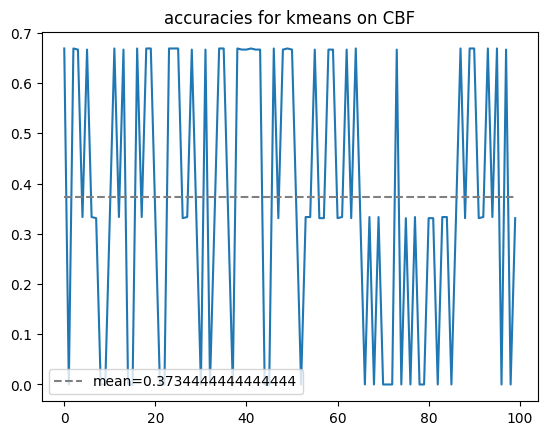

In [31]:
f, ax = plt.subplots()
ax.plot(accs)
ax.set_title(f"accuracies for kmeans on {config['dataset']['dataset_name']}")
ax.plot([mean_acc for _ in range(num_tests)], '--', c='grey', label=f"mean={mean_acc}")
ax.legend()
plt.show()

If it varies alot up and down it is due to kmeans not finding optimal clusters and the remap_cluster() not finding frequencies that change the labels good enough. For the remap cluster function to work it requires that the predicted cluster labels has the similar frequency as the true



In [32]:
Z_train, Z_test, Y_train, Y_test = train_test_split(zqs_test, y_test, test_size=0.2)

In [33]:
kmeans = KMeans(init="random", n_init=100, n_clusters=k, max_iter=300) 

kmeans.fit(Z_train)

KMeans(init='random', n_clusters=3, n_init=100)

In [34]:
Y_pred = kmeans.predict(Z_test)
Y_pred = remap_clusters(Y_pred, Y_test)

print("Accuracy:", metrics.accuracy_score(y_true=Y_test, y_pred=Y_pred))

Accuracy: 0.0


In [35]:
num_tests = 10
accs = np.zeros(num_tests)
for i in tqdm(range(num_tests)):
    kmeans = KMeans(init="random", n_init=100, n_clusters=k, max_iter=300) 
    kmeans.fit(Z_train)
    Y_pred = kmeans.predict(Z_test)
    Y_pred = remap_clusters(Y_pred, Y_test)
    accs[i] = metrics.accuracy_score(y_true=Y_test, y_pred=Y_pred)

mean_acc = np.mean(accs)

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


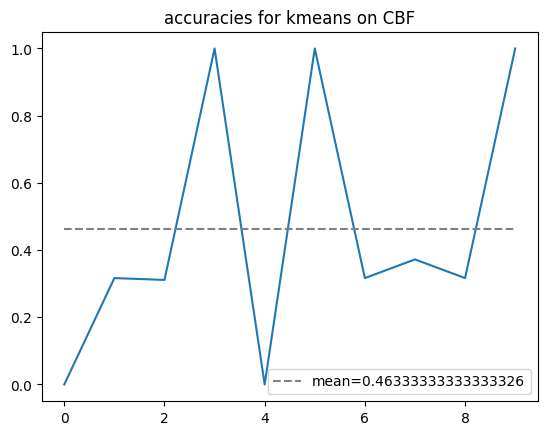

In [36]:
f, ax = plt.subplots()
ax.plot(accs)
ax.set_title(f"accuracies for kmeans on {config['dataset']['dataset_name']}")
ax.plot([mean_acc for _ in range(num_tests)], '--', c='grey', label=f"mean={mean_acc}")
ax.legend()
plt.show()